In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
import scipy.stats as stats

## Generate synthetic data

In [2]:
def generate_households(num_households=1, conflict_intensity: str = 'None', fix_seed=True):
    '''Generate dummy households.'''
    if fix_seed:
        np.random.seed(0)  # Ensure reproducibility

    data = {'exp_house': 0,
            'consumption_loss': 0,
            'consumption_loss_npv': 0,
            'net_consumption_loss': 0,
            'net_consumption_loss_npv': 0,
            'c_t': 0,
            'c_t_unaffected': 0,
            'wellbeing': 0}

    if conflict_intensity != 'None':
        d = {'Very low': {'mean': 1522.72, 'std': 980.51, 'min': 154.25, 'max': 5473.81},
             'Low': {'mean': 1333.83, 'std': 799.99, 'min': 226.35, 'max': 5439.8},
             'Medium': {'mean': 982.08, 'std': 666.34, 'min': 175.05, 'max': 5317.89},
             'High': {'mean': 1064.61, 'std': 809.55, 'min': 156.39, 'max': 5439.94},
             'Very high': {'mean': 637.02, 'std': 474.87, 'min': 152.8, 'max': 5172.65}}
        
        lower, upper = d[conflict_intensity]['min'], d[conflict_intensity]['max']
        mu, sigma = d[conflict_intensity]['mean'], d[conflict_intensity]['std']
        X = stats.truncnorm((lower - mu) / sigma,
                            (upper - mu) / sigma, loc=mu, scale=sigma)
        exp = X.rvs(num_households)
    else:
        # Let's take q=0.25 and q=0.75 as the lower and upper bounds
        lower, upper = 153, 5474
        mu, sigma = 1099, 1099
        X = stats.truncnorm((lower - mu) / sigma,
                            (upper - mu) / sigma, loc=mu, scale=sigma)
        exp = X.rvs(num_households)

    data['exp'] = exp
    # Income is a product of expenditure and a random coefficient
    inc_multiplier = 1.48  # for Nigeria
    inc_delta = 0.1
    low = inc_multiplier - inc_delta
    high = inc_multiplier + inc_delta
    data['inc'] = data['exp'] * np.random.uniform(low, high)

    sav_multiplier = 0.0204  # for Nigeria
    sav_delta = 0.02
    low = sav_multiplier - sav_delta
    high = sav_multiplier + sav_delta
    data['sav'] = data['inc'] * np.random.uniform(low, high)

    # divide by average productivity, 0.35 for Nigeria
    data['keff'] = data['inc'] / 0.35

    mean_vulnerability = {'Very low': 0.43,
                          'Low': 0.46,
                          'Medium': 0.66,
                          'High': 0.63,
                          'Very high': 0.65}

    if conflict_intensity != 'None':
        data['v'] = mean_vulnerability[conflict_intensity]
    else:
        data['v'] = np.random.uniform(0.2, 0.8, num_households)

    # Sort columns
    sorted_columns = ['exp', 'inc', 'sav', 'keff', 'exp_house', 'v', 'consumption_loss', 'consumption_loss_npv',
                      'net_consumption_loss', 'net_consumption_loss_npv', 'c_t', 'c_t_unaffected', 'wellbeing']

    return pd.DataFrame(data)[sorted_columns]

In [3]:
df = generate_households(conflict_intensity='Medium', fix_seed=True)

# Manually specify one of the Borno households
# df['exp'] = 1539
# df['sav'] = 7.0453004253
# df['v'] = 0.7035000936
# df['keff'] = 6887.7849214571

## Household consumption recovery

In [16]:
def calculate_consumption_recovery(df:pd.DataFrame, parameters:dict, print_statistics:bool=False) -> pd.DataFrame:
    '''Calculate consumption recovery'''
    initial_expenditure = df['exp'].values
    initial_savings = df['sav'].values
    effective_capital = df['keff'].values

    recovery_rate = parameters['recovery_rate']
    years_to_recover = parameters['years_to_recover']
    income_and_expenditure_growth = parameters['income_and_expenditure_growth']
    average_productivity = parameters['average_productivity']
    consumption_utility = parameters['consumption_utility']
    discount_rate = parameters['discount_rate']
    
    try:
        vulnerability_increase_factor = parameters['vulnerability_increase_factor']
        vulnerability = parameters['v']
    except:
        vulnerability_increase_factor = 1
        vulnerability = df['v'].values
    
    totaL_weeks = 52 * years_to_recover
    dt = 1 / 52
    consumption = {}
    consumption_unaffected = {}
    wellbeing = {}
    consumption_loss = {}
    consumption_loss_npv = {}

    for time in np.linspace(0, years_to_recover, totaL_weeks):
        exponential_multiplier = np.e**(-recovery_rate * time)
        growth_factor = (1 + income_and_expenditure_growth)**time

        current_expenditure = growth_factor * initial_expenditure
        current_savings = growth_factor * initial_savings * (1 / vulnerability_increase_factor) # * recovery_rate
        
        asset_loss = growth_factor * effective_capital * vulnerability * vulnerability_increase_factor * recovery_rate 
        income_loss = growth_factor * average_productivity * effective_capital * vulnerability * vulnerability_increase_factor # * recovery_rate
        # income_loss = 0

        c_t = np.maximum(current_expenditure + exponential_multiplier * (current_savings - asset_loss - income_loss), 0)
        c_t_unaffected = current_expenditure
        c_t = np.minimum(c_t, c_t_unaffected)
        
        consumption[time] = c_t
        consumption_unaffected[time] = c_t_unaffected
        consumption_loss[time] = dt * (c_t_unaffected - c_t)
        consumption_loss_npv[time] = dt * (c_t_unaffected - c_t)*np.e**(-discount_rate * time)

        # wellbeing[time] = c_t_unaffected**(1 - consumption_utility) / (1 - consumption_utility) * dt\
        #     * ((1 - ((c_t_unaffected - c_t) / c_t_unaffected) * np.e**(-recovery_rate * time))**(1 - consumption_utility) - 1)\
        #     * np.e**(-discount_rate * time)

    total_consumption_loss = sum(consumption_loss.values())
    total_consumption_loss_npv = sum(consumption_loss_npv.values())

    if print_statistics:
        print('Total consumption loss:', "{:,}".format(round(total_consumption_loss[0])))
        # print('Total consumption loss NPV:', "{:,}".format(round(total_consumption_loss_npv[0])))

    return pd.DataFrame(consumption), pd.DataFrame(consumption_unaffected), pd.DataFrame(consumption_loss), pd.DataFrame(consumption_loss_npv), pd.DataFrame(wellbeing)

In [17]:
def find_recovery_rate(**parameters) -> float:
    v = parameters['v']
    average_productivity = parameters['average_productivity']
    consumption_utility = parameters['consumption_utility']
    discount_rate = parameters['discount_rate']
    years_to_recover = parameters['years_to_recover']
    lambda_increment = parameters['lambda_increment']
    
    totaL_weeks = 52 * years_to_recover
    dt = 1 / 52

    lambda_value = 0
    last_derivative_lambda = 0

    while True:
        derivative_lambda = 0
        for time in np.linspace(0, years_to_recover, totaL_weeks):
            factor = average_productivity + lambda_value
            part1 = (average_productivity - factor * v *
                     np.exp(-lambda_value * time)) ** (-consumption_utility)
            part2 = time * factor - 1
            part3 = np.exp(-time * (discount_rate + lambda_value))
            derivative_lambda += part1 * part2 * part3 * dt

        if (last_derivative_lambda < 0 and derivative_lambda > 0) or (last_derivative_lambda > 0 and derivative_lambda < 0) or lambda_value > years_to_recover:
            return lambda_value

        last_derivative_lambda = derivative_lambda
        lambda_value += lambda_increment

### Without conflict

Total consumption loss: 4,490


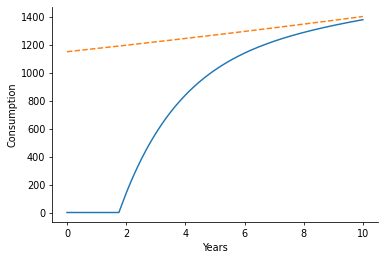

In [18]:
default_parameters = {'recovery_rate': 0.5, 
                      'years_to_recover': 10, 
                      'income_and_expenditure_growth': 0.02,
                      'average_productivity': 0.35,
                      'consumption_utility': 1.5,
                      'discount_rate': 0.04}

consumption, consumption_unaffected, consumption_loss, consumption_loss_npv, wellbeing = calculate_consumption_recovery(df, default_parameters, print_statistics=True)

ax = consumption.T.plot(legend=False)
consumption_unaffected.T.plot(ax=ax, legend=False, linestyle='--')
plt.xlabel('Years')
plt.ylabel('Consumption');

# ax = consumption_loss.T.plot(legend=False)
# plt.xlabel('Years')
# plt.ylabel('Consumption loss')
sns.despine()

In [19]:
# One factor at the time
default_parameters = {'recovery_rate': 0.2,
                      'years_to_recover': 10,
                      'income_and_expenditure_growth': 0.02,
                      'average_productivity': 0.35,
                      'consumption_utility': 1.5,
                      'discount_rate': 0.04}

experimental_parameters = {# 'recovery_rate': [0.1, 0.3, 0.5, 0.7, 0.9, 1],
                           # 'recovery_rate' : [0.02, 0.04, 0.07, 0.21, 0.27],
                           'income_and_expenditure_growth': [0.01, 0.0125, 0.015 , 0.0175, 0.019, 0.02],
                           # 'average_productivity': [0.2, 0.25, 0.3, 0.35],
                           # 'years_to_recover': [5, 10, 15, 20, 25]
                           }
results = {}
for key, values in experimental_parameters.items():
    d = {}
    for v in values:
        parameters = default_parameters.copy()
        parameters[key] = v
        print(key, v)
        d[v], _, _, _, _ = calculate_consumption_recovery(
            df, parameters, print_statistics=True)
        print()
    d = pd.concat(d)
    d.index = d.index.droplevel(1)
    d.index.name = key
    results[key] = d

income_and_expenditure_growth 0.01
Total consumption loss: 7,309

income_and_expenditure_growth 0.0125
Total consumption loss: 7,377

income_and_expenditure_growth 0.015
Total consumption loss: 7,446

income_and_expenditure_growth 0.0175
Total consumption loss: 7,515

income_and_expenditure_growth 0.019
Total consumption loss: 7,558

income_and_expenditure_growth 0.02
Total consumption loss: 7,586



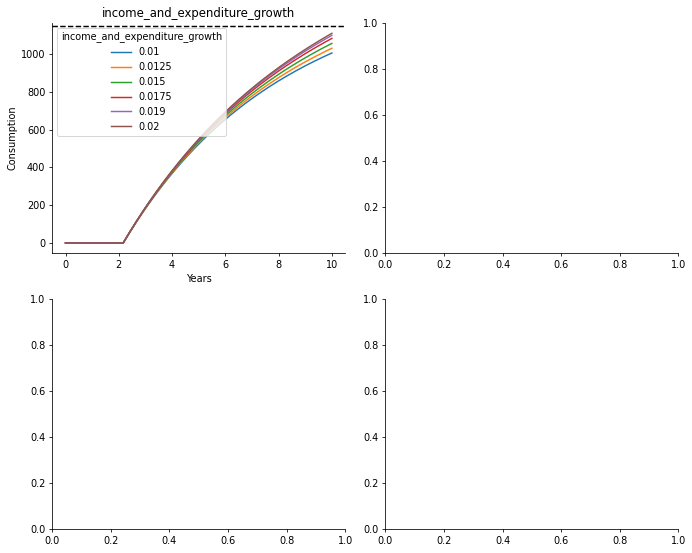

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for (key, value), ax in zip(results.items(), axes.flatten()):
    value.T.plot(ax=ax, legend=True)
    ax.set_title(key)
    ax.set_xlabel('Years')
    ax.set_ylabel('Consumption')
    sns.despine()
    ax.axhline(df['exp'][0], color='k', linestyle='--')
fig.tight_layout()

In [9]:
default_parameters = {'recovery_rate': 0.2,
                      'years_to_recover': 10,
                      'income_and_expenditure_growth': 0.02,
                      'average_productivity': 0.35,
                      'consumption_utility': 1.5,
                      'discount_rate': 0.04}

results = {}
n_households = 10
for i in tqdm(range(n_households)):
    df = generate_households(fix_seed=False, conflict_intensity='Very high')
    for r in [0.1, 0.3, 0.5, 0.7, 0.9, 1]:
        parameters = default_parameters.copy()
        parameters['recovery_rate'] = r
        _, _, consumption_loss, _, _ = calculate_consumption_recovery(df, parameters, print_statistics=False)
        total_consumption_loss = consumption_loss.sum(axis=1).values[0]
        results[r] = total_consumption_loss
    assert results[0.1] > results[0.3] > results[0.5] > results[0.7] > results[0.9] > results[1]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


### With conflict

In [21]:
# average_productivity: min > 0.22, max < 0.98
# consumption_utility: min > 0.61, max < 10
# discount_rate: min > 0.01, max < 0.3
# v: min > 0.13, max < 0.98

In [29]:
default_parameters = {'average_productivity': 0.35,
                      'income_and_expenditure_growth': 0.02,
                      'consumption_utility': 1.5,
                      'discount_rate': 0.04,
                      'lambda_increment': 0.01,
                      'years_to_recover': 10,
                      'v' : 0.52}

experimental_parameters = {'average_productivity': [0.225     , 0.27248175, 0.31256775, 0.35551575, 0.407052  ,0.45],
                           'v': [0.66, 0.63, 0.60, 0.46, 0.43, 0.43],
                           'income_and_expenditure_growth': [0.001    , 0.00482  , 0.0082478, 0.0119204, 0.0163274, 0.02     ],
                           'vulnerability_increase_factor': [1.05   , 1.02997, 1.0232 , 1.01595, 1.00725, 1.     ],
                           }

df = generate_households()
parameters = default_parameters.copy()
results = {}
for i, conflict_intensity in enumerate(['Very high', 'High', 'Medium', 'Low', 'Very low', 'None']):
    parameters['average_productivity'] = experimental_parameters['average_productivity'][i]
    parameters['v'] = experimental_parameters['v'][i]
    parameters['income_and_expenditure_growth'] = experimental_parameters['income_and_expenditure_growth'][i]
    parameters['vulnerability_increase_factor'] = experimental_parameters['vulnerability_increase_factor'][i]
    parameters['recovery_rate'] = find_recovery_rate(**parameters)
    results[conflict_intensity], _, consumption_loss, _, _ = calculate_consumption_recovery(df, parameters, print_statistics=False)
    print(f'{conflict_intensity} / Total consumption loss = {round(consumption_loss.sum(axis=1).values[0])}')

Very high / Total consumption loss = 9499
High / Total consumption loss = 10143
Medium / Total consumption loss = 9912
Low / Total consumption loss = 6655
Very low / Total consumption loss = 5794
None / Total consumption loss = 5682


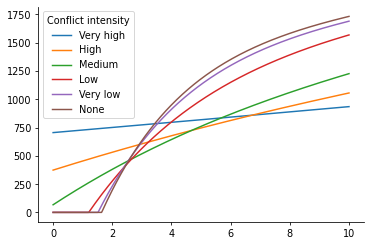

In [11]:
fig, ax = plt.subplots()
# baseline.T.plot(ax=ax, linestyle='--', color='gray', linewidth=5, figsize=(6,4))
# labels = ['Baseline']
labels = []
for key, value in results.items():
    value.T.plot(ax=ax)
    labels.append(key)
ax.legend(labels=labels, title='Conflict intensity');
sns.despine();

## Wellbeing

In [3]:
default_parameters = {'recovery_rate': 0.5, 
                      'years_to_recover': 10, 
                      'income_and_expenditure_growth': 0.02,
                      'average_productivity': 0.35,
                      'consumption_utility': 1.5,
                      'discount_rate': 0.04}

consumption, consumption_unaffected, total_consumption_loss, total_consumption_loss_npv, wellbeing = calculate_consumption_recovery(df, default_parameters)

ax = consumption.T.plot(legend=False)
consumption_unaffected.T.plot(ax=ax, legend=False, linestyle='--')
print('Total consumption loss:', total_consumption_loss)
print('Total consumption loss NPV:', total_consumption_loss_npv)

# consumption_utility = 1.5
# weighted_average_expenditure = df['exp'].values[0]
# welfare = weighted_average_expenditure ** (-consumption_utility)
# wellbeing = wellbeing.sum().values[0]
# wellbeing = 1
# total_consumption_equivalent_loss = wellbeing / welfare
# total_asset_damage = (df['keff'] * df['v']).values[0]
# r = total_asset_damage / total_consumption_equivalent_loss

# print(f'Weighted average expenditure: {weighted_average_expenditure:,.5f}')
# print(f'Welfare: {welfare:,.5f}')
# print(f'Wellbeing: {wellbeing:,.5f}')
# print(f'Total consumption equivalent loss: {total_consumption_equivalent_loss:,.5f}')
# print(f'Total asset damage: {total_asset_damage.sum():,.5f}')
# print(f'Socio-economic resilience: {r:,.5f}')

plt.xlabel('Years')
plt.ylabel('Consumption');

NameError: name 'df' is not defined

## Recovery rate

### General exploration 

In [4]:
def find_recovery_rate(v: float, average_productivity: float, consumption_utility: float, discount_rate: float, lambda_increment: float, years_to_recover: int) -> float:
    totaL_weeks = 52 * years_to_recover
    dt = 1 / 52

    lambda_value = 0
    last_derivative_lambda = 0

    while True:
        derivative_lambda = 0
        for time in np.linspace(0, years_to_recover, totaL_weeks):
            factor = average_productivity + lambda_value
            part1 = (average_productivity - factor * v *
                     np.exp(-lambda_value * time)) ** (-consumption_utility)
            part2 = time * factor - 1
            part3 = np.exp(-time * (discount_rate + lambda_value))
            derivative_lambda += part1 * part2 * part3 * dt

        if (last_derivative_lambda < 0 and derivative_lambda > 0) or (last_derivative_lambda > 0 and derivative_lambda < 0) or lambda_value > years_to_recover:
            return lambda_value

        last_derivative_lambda = derivative_lambda
        lambda_value += lambda_increment

In [6]:
results = {}

default_parameters = {'v': 0.5,
                      'discount_rate': 0.04, 
                      'average_productivity': 0.35, 
                      'consumption_utility': 1.5,
                      'lambda_increment' : 0.01,
                      'years_to_recover': 10}

experimental_parameters = {'average_productivity': np.arange(0.01, 10, 0.01),
                           'consumption_utility': np.arange(0.01, 10, 0.1),
                           'discount_rate': np.arange(0.01, 1, 0.01),
                           'v': np.arange(0.01, 1, 0.01)}

default_recovery_rate = find_recovery_rate(**default_parameters)
print(default_recovery_rate)

results = {}
for key, values in tqdm(experimental_parameters.items(), desc='Parameter'):
    d = {}
    for v in values:
        parameters = default_parameters.copy()
        parameters[key] = v
        d[v] = find_recovery_rate(**parameters)
    results[key] = d

In [62]:
# Tipping point for average productivity = 0.3 (from max to normal)
# Tipping point for consumption utility = 0.7 (from max to normal)
# Tipping point for discount rate = 0.2 (from normal to max)
# Tipping point for v = 0.1 (from max to normal)

x_limits = {'average_productivity': 0.3,
            'consumption_utility': 1.1,
            'discount_rate': 0.2,
            'v': 0.2}

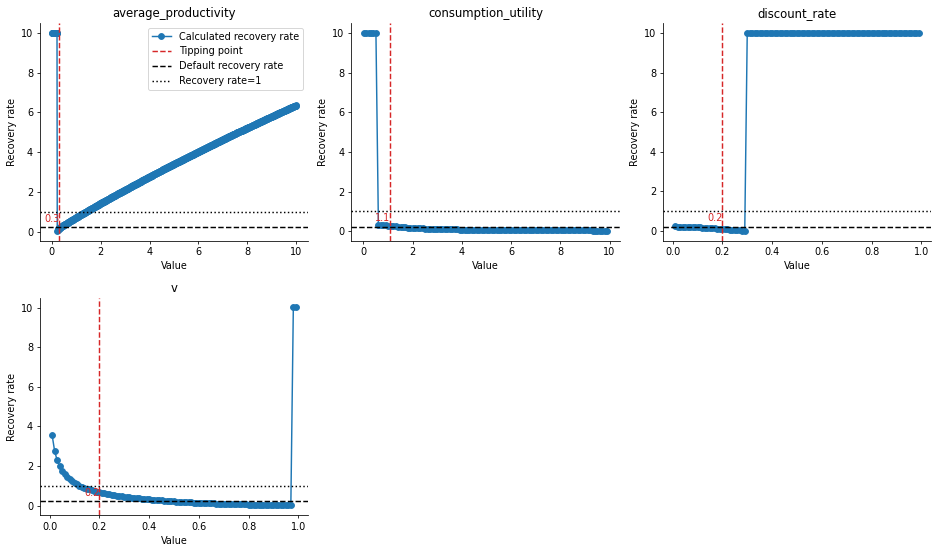

In [63]:
# Visualize results
ncols = 3
nrows = int(np.ceil(len(results) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 4), sharex=False, sharey=False)
axes = axes.flatten()
for i, (key, value) in enumerate(results.items()):   
    pd.Series(value).plot(ax=axes[i], legend=False, marker='o')

    # Add tipping points as vertical lines
    if key in x_limits:
        axes[i].axvline(x_limits[key], color='tab:red', linestyle='--')
        axes[i].text(x_limits[key], 0.5, f'{x_limits[key]}', color='tab:red', ha='right')

    axes[i].axhline(default_recovery_rate, color='k', linestyle='--')
    axes[i].set_title(key)
    sns.despine()
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Recovery rate')
    axes[i].axhline(1, color='k', linestyle=':')
    if i == 0:
        axes[i].legend(['Calculated recovery rate', 'Tipping point', 'Default recovery rate', 'Recovery rate=1'])

for i in range(len(results), len(axes)):
    fig.delaxes(axes[i])
fig.tight_layout()

In [55]:
# Identify the tipping points for each parameter
tipping_points = {}
# For average productivity, consumption utility, and v search until r > 1
for key, value in results.items():
    if key != 'discount_rate':
        for v, r in value.items():
            if r > 1:
                continue
            else:
                tipping_points[key] = v
                break
    else:
        for v, r in value.items():
            if r > 1:
                tipping_points[key] = v
                break

In [ ]:
# average_productivity min > 0.22
# average_productivity max < 0.98

# consumption_utility min > 0.61
# consumption_utility max < 10

# discount_rate min > 0.01
# discount_rate max < 0.3

# v min > 0.13
# v max < 0.98

In [56]:
tipping_points

{'average_productivity': 0.22,
 'consumption_utility': 0.6100000000000001,
 'discount_rate': 0.3,
 'v': 0.13}

### Conflict

In [9]:
results = {}

default_parameters = {'v': 0.5,
                      'discount_rate': 0.04, 
                      'average_productivity': 0.35, 
                      'consumption_utility': 1.5,
                      'lambda_increment' : 0.01,
                      'years_to_recover': 10}

experimental_parameters = {'average_productivity': [0.225     , 0.25  , 0.275, 0.3, 0.325, 0.35],
                           # 'v': [0.65, 0.63, 0.66, 0.46, 0.43]
                           'v': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                           }

default_recovery_rate = find_recovery_rate(**default_parameters)
print(default_recovery_rate)

results = {}
conflict_intensity = ['Very high', 'High', 'Medium', 'Low', 'Very low', 'None']
i = 0
for average_productivity, v in zip(experimental_parameters['average_productivity'], experimental_parameters['v']):
    parameters = default_parameters.copy()
    parameters['average_productivity'] = average_productivity
    parameters['v'] = v
    results[conflict_intensity[i]] = find_recovery_rate(**parameters)
    i += 1

0.21000000000000005


In [10]:
pd.Series(results).values

array([0.06, 0.11, 0.14, 0.16, 0.19, 0.21])

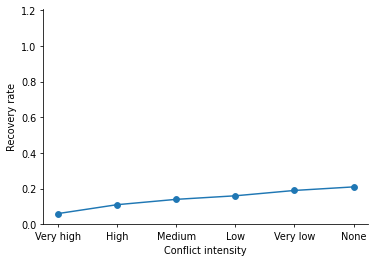

In [11]:
fig, ax = plt.subplots()
pd.Series(results).plot(ax=ax, marker='o', legend=False)
plt.xlabel('Conflict intensity')
plt.ylabel('Recovery rate')
sns.despine() 
plt.ylim(0, max(results.values()) + 1);

In [7]:
df = pd.read_csv('../../data/processed/household_survey/Nigeria.csv')
conflict = pd.read_excel('../../data/processed/conflict/Nigeria.xlsx')
df = pd.merge(df, conflict[['region', 'conflict_intensity']], on='region', how='left')

In [15]:
df.groupby('conflict_intensity')['v_init'].describe().loc[['Very low', 'Low', 'Medium', 'High', 'Very high'], :]['mean'].values

array([0.42996663, 0.46403838, 0.65611667, 0.62851028, 0.654366  ])

## Income loss

In [ ]:
def calculate_income_loss(parameters):
    years_to_recover = parameters['years_to_recover']
    total_weeks = 52 * years_to_recover
    recovery_rate = parameters['recovery_rate']
    income_and_expenditure_growth = parameters['income_and_expenditure_growth']
    average_productivity = parameters['average_productivity']
    effective_capital = parameters['effective_capital']
    vulnerability = parameters['vulnerability']
    vulnerability_increase_factor = parameters['vulnerability_increase_factor']
    income_loss = {}
    for time in np.linspace(0, years_to_recover, total_weeks):
        exponential_multiplier = np.e**(-recovery_rate * time)
        growth_factor = (1 + income_and_expenditure_growth)**time
        income_loss[time] = growth_factor * average_productivity * effective_capital * vulnerability * vulnerability_increase_factor # * recovery_rate
    return pd.DataFrame(income_loss, index=[0])

In [ ]:
default_parameters = {'years_to_recover': 10,
                      'recovery_rate': 0.09,
                      'effective_capital': 6887.7849214571,
                      'vulnerability': 0.7035000936,
                      'vulnerability_increase_factor': 1,
                      'income_and_expenditure_growth': 0.02,
                      'average_productivity': 0.35}

experimental_parameters = {'income_and_expenditure_growth': [0.0000266, 0.000266, 0.00482 , 0.010892, 0.016964, 0.02], 
                           'average_productivity': [0.01720495, 0.1720495, 0.213115, 0.267869, 0.322623, 0.35]}

results = {}

for key, values in experimental_parameters.items():
    d = {}
    for v in values:
        parameters = default_parameters.copy()
        parameters[key] = v
        d[v] = calculate_income_loss(parameters)
    d = pd.concat(d)
    d.index = d.index.droplevel(1)
    d.index.name = key
    results[key] = d

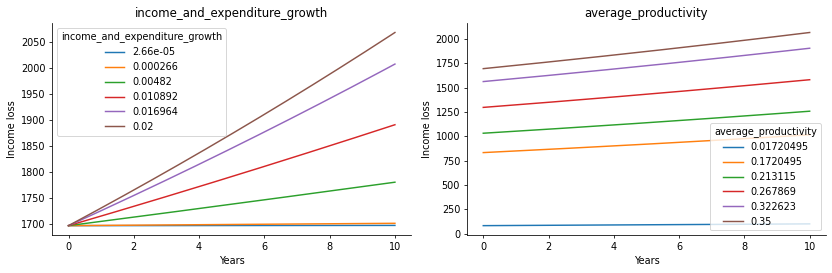

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for (key, value), ax in zip(results.items(), axes.flatten()):
    value.T.plot(ax=ax, legend=True)
    ax.set_title(key)
    ax.set_xlabel('Years')
    ax.set_ylabel('Income loss')
    sns.despine()
fig.tight_layout()